## Example Introduction

This catalog contains a lot of examples.
There content vary depending upon what problem it is trying to address.
However, there is a common theme to the problem being discussed across the examples.
So as an introduction, it perhaps useful to take a look at the example being worked at.

The example code snippets in this section is also importable from the submodule `chaospy.example`.

### Dependency imports

The software library ``chaospy`` is meant to be used together with the standard library ``numpy``. In addition we will use ``matplotlib.pyplot`` to plot results.

In [1]:
import chaospy
import numpy
from matplotlib import pyplot

In addition there are other imports as well for some specialized examples. They are noted where relevant in each of the tutorials.

### Model Predictor

At the core of any forward problem, stochastic or otherwise, you will find the model predictor or model solver.
Typically most problems starts with a set of governing equations that needs to be solved.
The model predictor will in this case represent the forward predictor that allows the user to create predictions.
However as we are trying to address uncertain parameter, making a single solution will likely not do.
Instead the parameters needs to be an input in the model predictor, and the governing equations have to be solved specifically for the provided input.

In other words, we expect the model predictor to be deterministic.
It should typically expect some form of ``parameters`` vector as input.
And to keep things simple, we assume that the return value for the predictor is either scalar or some sort of ``numpy.ndarray`` vector.

As these tutorials are all meant for demonstrative purposes only, we keep things simple.
We limit the number of parameters to two: initial condition and exponential rate, use a minimal exponential function as model, which output equal in size to a predefined array ``coordinates`` as input.

In [2]:
coordinates = numpy.linspace(0, 10, 1000)


def exponential_model(parameters, coordinates=coordinates):
    """
    Over simplistic exponential model function.

    Args:
        parameters (numpy.ndarray):
            Hyper-parameters defining the model initial
            conditions and exponential growth rate.
            Assumed to have ``parameters.shape == (2,)``.
        coordinates (numpy.ndarray):
            The spatio-temporal coordinates.

    Returns:
        (numpy.ndarray):
            Evaluation of the exponential model.
            Same shape as ``coordinates``.
    """
    param_init, param_rate = parameters
    return param_init*numpy.e**(-param_rate*coordinates)

We can then use the model by passing only the two hyper-parameters:

In [3]:
exponential_model([1.2, 3.2])[:4].round(6)

array([1.2     , 1.162171, 1.125534, 1.090052])

### Parameter Probability Distribution

Even though ``model_predictor`` is assumed to be deterministic, we are still trying to quantify model uncertainty.
We do this by assuming that the uncertainty in the model is limited to the ``parameters``, which can be split into the variables ``init`` and ``rate`` referring to initial condition and exponential rate respoectively.
To reduce the uncertainty down to a finite set of parameters often require some model assumptions to be made.
However what model assumption to make is a little bit outside the scope of these tutorials.

In any case, we assume that the ``parameters`` are unknown, and can be described through a probability joint probability distribution.
In our tiny example, we assume that the ``parameters`` can be described through a bivariate uniform probability distribution:

In [4]:
distribution_init = chaospy.Normal(1.5, 0.2)
distribution_rate = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(distribution_init, distribution_rate)

This distribution can be visualized as follows:

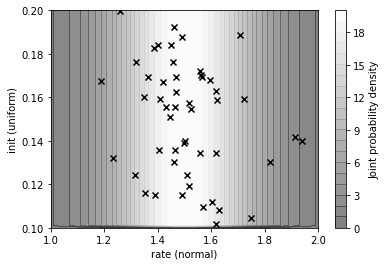

In [5]:
# Create contour plot for the probability density function
grid_init, grid_rate = grid = numpy.meshgrid(
    numpy.linspace(1, 2, 100), numpy.linspace(0.1, 0.2, 100))
contour = pyplot.contourf(
    grid_init, grid_rate, distribution.pdf(grid),
    levels=20, cmap="gray", alpha=0.5)
colorbar = pyplot.colorbar(contour)

# Create scatter plot for 50 random samples
numpy.random.seed(123)
samples = distribution.sample(50)
pyplot.scatter(*samples, marker="x", color="k")

# Make figure pretty
pyplot.axis([1, 2, 0.1, 0.2])
pyplot.xlabel("rate (normal)")
pyplot.ylabel("init (uniform)")
colorbar.ax.set_ylabel("Joint probability density")

pyplot.show()

### Model Evaluations

Random samples created from the distribution can be passed to the model solver, creating random realizations of the model solutions.

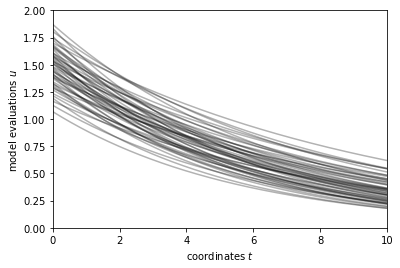

In [6]:
# Make a plot line for the first 50 evaluations
for params in distribution.sample(50, rule="halton").T:
    pyplot.plot(
        coordinates, exponential_model(params), "k-", alpha=0.3)

# Make figure pretty
pyplot.axis([0, 10, 0, 2])
pyplot.xlabel("coordinates $t$")
pyplot.ylabel("model evaluations $u$")

pyplot.show()

### Reference solution

Our goal here is to describe the behavior of ``model_predictor`` with only having a black-box evaluation of the function available.

To be able to assess how well the various methods works for this example, we asses how well the various methods is to estimate the _mean_ and _variance_ for the model solution.
To do so, we need the reference value to compare against.
Specifically:

$$
 \begin{align*}
  \mbox E(I e^{-Rt}) =& \iint i e^{-rt} p(i, r) \ di\ dr = 15 (e^{-0.1t}\!-\!e^{-0.2t}) / t \\
  \mbox{Var}(I e^{-Rt}) =& \iint (i e^{-at} \!-\! \mbox E)Ie^{-Rt}))^2 p(i, r)\ di\ da = 11.45 (e^{-0.2t}\!-\!e^{-0.4t}) /t \!-\! \mbox E(I e^{-Rt})^2
 \end{align*}
$$

where $t$ are coordinates, and $p(i, r)$ is init and rate joint probability density function.
Here we use the variables $i/I$ and $r/R$ are shorthands for `init` and `rate`.

Which numerically becomes:

In [7]:
t = coordinates[1:]

true_mean = 15*(numpy.e**(-0.1*t)-numpy.e**(-0.2*t))/t
true_mean = numpy.hstack([1.5, true_mean])

true_variance = 11.45*(numpy.e**(-0.2*t)-numpy.e**(-0.4*t))/t
true_variance = numpy.hstack([2.29, true_variance]) 
true_variance -= true_mean**2

To summarize how close a particular estimator is, we use the average absolute difference between estimated and true value.
In other words:

In [8]:
def error_mean(prediction_mean, true_mean=true_mean):
    """
    How close the estimated mean is the to the true mean.

    Args:
        prediction_mean (numpy.ndarray):
            The estimated mean.
        true_mean (numpy.ndarray):
            The reference mean value. Must be same shape as
            ``prediction_mean``.

    Returns:
        (float):
            The mean absolute distance between predicted
            and true values.
    """
    return numpy.mean(numpy.abs(prediction_mean-true_mean))


def error_variance(predicted_variance,
                   true_variance=true_variance):
    """
    How close the estimated variance is the to the true variance.

    Args:
        prediction_variance (numpy.ndarray):
            The estimated variance.
        true_variance (numpy.ndarray):
            The reference variance value.
            Must be same shape as ``prediction_variance``.

    Returns:
        (float):
            The mean absolute distance between
            predicted and true values.
    """
    return numpy.mean(numpy.abs(predicted_variance-true_variance))

It is worth noting that calculating the reference solution analytically is not always possible.
In those cases, it is not uncommon to for example use Monte Carlo Integration with a prohibitively large number of samples.
In the scale of for example $10^8$ number of samples.